# <ins>Slice: Data Science Case Study on Churn and Behavioural Analysis</ins>



In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://is1-ssl.mzstatic.com/image/thumb/Purple113/v4/2d/99/b6/2d99b613-2502-2410-530a-056ff38e1dc9/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/400x400.png")

#### Slice wants to analyze customer churn patterns. We will create acquisition and behavioural cohorts and identify any actionable insights.


We have been provided with some sample data and will begin by exploring, cleaning and then analysing the dataset.

In [2]:
import pandas as pd
df = pd.read_excel('C://downloads/churn.xlsx')
df.head()

,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id,state,postal_code
0,47433960,iosapp,2019-03-13T08:02:07.000Z,Delivery,credit,0,15.50,1.331507e+10,24597,MD,21162
1,47434359,iosapp,2019-03-13T08:11:38.000Z,Delivery,credit,0,24.83,1.555713e+10,64392,NY,12944
2,47437194,partner_website,2019-03-13T09:07:31.000Z,Delivery,cash,0,43.24,2.568937e+10,33699,NJ,8007
3,47442942,partner_website,2019-03-13T11:01:04.000Z,Delivery,credit,0,27.95,2.542111e+10,19002,WI,53235
4,47443107,partner_website,2019-03-13T11:04:56.000Z,Delivery,credit,0,23.15,1.852919e+10,34911,MA,2122


The date_purchased column is currently a string so we will convert that to a date. We will then go on to look for missing values.

In [3]:
df.date_purchased = pd.to_datetime(df.date_purchased)

In [4]:
print("\033[4mMissing Values\033[0m")
for i in df.columns:
    if pd.isna(df[i]).any():
       print(i+":", pd.isna(df[i]).sum())

Missing Values
date_purchased: 9
customer: 5
state: 59


There are some interesting results in the summary statistics, but first we will delete or impute the rows with missing data. We will delete the missing customer ID data. Each ID is a unique identifier for that customer, without it we cannot analyse the customers behaviour.

In [5]:
df= df.dropna(subset=["customer"])
df = df.reset_index(drop=True)

Next let us inspect the datetimes and order IDs to see if we can impute missing values.

In [6]:
from matplotlib import pyplot as plt
from datetime import datetime 

df2 = df.copy()
df2 = df2.dropna()
datetime = df2.date_purchased.dt.to_pydatetime()

plt.xlabel("Purchase Date")
plt.xticks(rotation=45)
plt.ylabel("Order ID")
plt.scatter(datetime, df2.order_id)

As order_id and date_purchased monotonically increase we can assume the dataset is sorted by time and that barring a few anomalies likely due to lag in processing times, a larger order_id value coincides with a later date. There are also a high enough frequency of orders such that each row increments by small deviations in time, therefore we can impute the missing datetimes by interpolation. For example, if we have a missing value between 4pm and 6pm on the same day we can simply estimate the time to be 5pm.

In [7]:
import numpy as np 
s = pd.Series(df['date_purchased'].values.astype(float))
s[s<0] = np.NaN
df['date_purchased'] = pd.to_datetime(s.interpolate())

On inspection of the file there seemed to be two different errors with states. Some state's values were blank. There were also 52 unique non-blank codes. One of which was NA, which is not a state and looks to be an error. For both of these cases we can match the postal_code column to state column and fill the correct states. In python both blank values and the string NA are treated a NaN so we only needed to fill the NaN values, but it was worth noting the two types of issues with the data as they may occur at different stages of a decoding process. 

In [8]:
pcodes = df[df.state.isna()]['postal_code'].unique()
df[df['postal_code'] == pcodes[1]]


,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id,state,postal_code
3210,52020675,partner_website,2019-05-11 20:27:43,Delivery,credit,0,40.64,2.594956e+10,40266,NaN,29577
8867,58716813,iosapp,2019-08-04 17:25:34,Delivery,credit,0,13.33,1.621335e+10,25143,SC,29577
34483,79546389,iosapp,2020-03-20 13:18:59,Delivery,credit,0,45.22,2.443775e+10,142143,SC,29577


As the postal_code matches we can assume the correct state is SC. However, not every postal_code may have a match.

We may also be able to find the state other ways. According to open source information (Google), postal code 15116 is PA. This works for all the codes except 1250. We may have access to other data to find the geolocation, for example IP addresses. For now we will replace all the values we know and delete the four rows we cannot identify for 1250.  

In [9]:
postal_list = [15116,29577,11368,1588,60016,19473,11207,21040,8096,95014,8648,19038,11779,33908,90036,10704]
state_list = ['PA','SC','NY','MA','IL','PA','NY','MD','NJ','CA','NJ','PA','NY','FL','CA','NY']

for i in range(len(postal_list)):
    df.loc[df['postal_code'] == postal_list[i], 'state'] = state_list[i]

In [10]:
df = df.dropna(subset=["state"])
df = df.reset_index(drop=True)
print("\033[4mMissing Values\033[0m")
df.isna().any()

Missing Values


order_id            False
source              False
date_purchased      False
shipping_type       False
payment_method      False
promo_value         False
restaurant_total    False
customer            False
shops_id            False
state               False
postal_code         False
dtype: bool

Now we can see there is no missing data in any column. It is worth checking the unique values of our columns with categorical data is check each category makes sense. We see in the payment_method column some values with a "/" instead of cash or credit. The other values in these rows all make sense and the customers have all previously purchased, therefore we won't remove this data.


Moving forward and talking with data engineers we could see how these issues arrive and try to fix them at the decoding stage or build algorithms using lookup tables to automate some of the previous steps. For example, I could use a postal_code database to update any missing state data. Shops would also have records of payment methods and so we could impute that data if needed.

We will now start some exploratory data analysis:



In [11]:
df.describe()

,order_id,promo_value,restaurant_total,customer,shops_id,postal_code
count,4.218900e+04,42189.000000,42189.000000,4.218900e+04,42189.000000,42189.000000
mean,6.891620e+07,0.112920,32.521999,1.861481e+10,39957.498187,28752.717035
std,1.048866e+07,0.609104,21.399268,1.029921e+11,32416.972910,28044.788442
min,4.743396e+07,0.000000,-3.000000,1.920771e+09,165.000000,1001.000000
25%,6.031562e+07,0.000000,20.340000,1.226172e+10,17085.000000,8731.000000
50%,7.022114e+07,0.000000,28.340000,1.847162e+10,34032.000000,19008.000000
75%,7.774436e+07,0.000000,39.340000,2.452697e+10,48513.000000,34997.000000
max,8.634656e+07,5.000000,1142.850000,2.111880e+13,147024.000000,99654.000000


We need to remove anomalous data within the restaurant_total column.

In [12]:
df.sort_values('restaurant_total').iloc[np.r_[0:5, -5:0]]

,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id,state,postal_code
3212,52025079,iosapp,2019-05-12 07:56:32,Delivery,credit,4,-3.00,2.753310e+10,43305,NY,11373
14562,64344108,androidapp,2019-10-12 13:38:25,Delivery,credit,0,0.00,1.043545e+10,19623,NY,10459
17249,67107639,partner_website,2019-11-08 17:21:41,Pickup,credit,0,0.00,1.891872e+10,60138,IL,60187
6228,55932807,iosapp,2019-06-30 17:45:55,Delivery,credit,0,0.00,6.047684e+09,31560,NJ,7030
6227,55932687,iosapp,2019-06-30 17:44:58,Delivery,credit,0,0.00,6.047684e+09,31560,NJ,7030
11013,60813066,partner_website,2019-08-31 10:38:54,Delivery,credit,0,378.79,2.111664e+10,71703,VA,22301
26667,74494062,partner_website,2020-01-30 07:32:19,Delivery,credit,0,390.82,1.940802e+10,5721,NY,10037
31991,77971170,partner_website,2020-03-04 08:23:26,Delivery,credit,0,400.31,1.940802e+10,5721,NY,10037
27597,75131721,partner_website,2020-02-05 10:20:51,Delivery,credit,0,410.80,9.323564e+09,9933,CA,90034
776,48652218,slicelife,2019-03-29 14:01:18,Delivery,credit,0,1142.85,2.847930e+10,12984,CA,94114


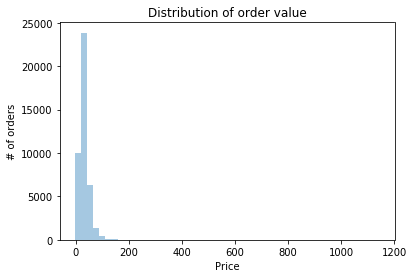

In [13]:
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')
ax = sns.distplot(df['restaurant_total'], kde=False, hist=True)
ax.set(title='Distribution of order value',
       xlabel='Price',
       ylabel='# of orders');

[Text(0,0.5,'# of customers'),
 Text(0.5,0,'ordervalue'),
 Text(0.5,1,'Distribution of order value per customer')]

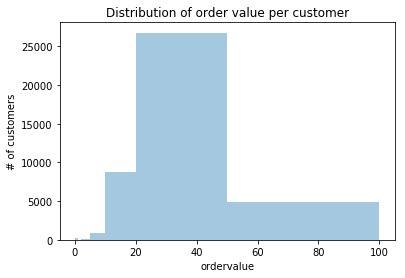

In [14]:
ax = sns.distplot(df['restaurant_total'], kde=False, hist=True, bins = [0,1,2,5,10,20,50,100])
ax.set(title='Distribution of order value per customer',
       xlabel='ordervalue',
       ylabel='# of customers')

The largest order value is odd as an order for over \\$1000 for Pizza isn't very common! This customer only ordered once and we can assume this order was for a large event. It is in California so perhaps Google or a similar large firm had a pizza day. We will remove this data point so we do not skew our results. The majority of orders are between \\$20 and \\$40 which we would have expected. 

In [15]:
df = df.drop(df[df.restaurant_total > 1140].index)
df = df.reset_index(drop=True)
df[df.customer == 27533104544]

,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id,state,postal_code
3211,52025079,iosapp,2019-05-12 07:56:32,Delivery,credit,4,-3.00,2.753310e+10,43305,NY,11373
3445,52341966,partner_website,2019-05-16 17:11:44,Delivery,cash,0,21.99,2.753310e+10,27264,NY,11368
29291,76207662,partner_website,2020-02-15 14:28:35,Delivery,credit,0,20.23,2.753310e+10,27264,NY,11368


The second result that stuck out was strange as the restaurant received negative dollars. I am inclined not to delete this data point though as the customer had a promo value of 4 dollars and the same customer came back and ordered two more times with more sensible values. The customer ordered again 4 days later, but then not again for over 6 months, which is the type of customer journey we would like to understand such that we can decrease the time between orders from 6 months back to a few days! If this negative result wasn't the first order, it may be reflective of refunds, but that doesn't make sense as the first order, some type of promotion is more likely. The negative value isn't large enough to skew any data.

We will now explore the distribution or orders from each customer as this may help us with our analysis later

In [16]:
n_orders = df.groupby(['customer'])['order_id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')


69.77% of customers ordered more than once.


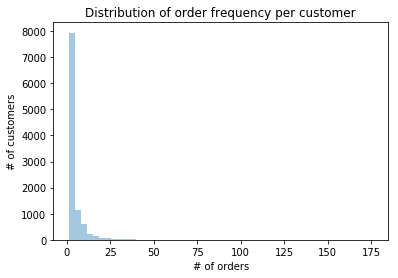

In [17]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of order frequency per customer',
       xlabel='# of orders',
       ylabel='# of customers');

[Text(0,0.5,'# of customers'),
 Text(0.5,0,'# of orders'),
 Text(0.5,1,'Distribution of order frequency per customer')]

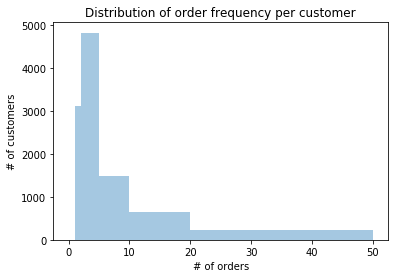

In [18]:
ax = sns.distplot(n_orders, kde=False, hist=True, bins = [0,1,2,5,10,20,50])
ax.set(title='Distribution of order frequency per customer',
       xlabel='# of orders',
       ylabel='# of customers')

We see the majority of our customers only purchase up to 5 times a year. We may want to compare the behaviour between those users, and those who are frequent buyers. This data also means we can expect quite a high churn as time goes on, but we do not know when those reorders take place yet, they could be within the first week or six months later. 


Now our data is ready and we understand it a bit better we will start our cohort analysis, first looking at acquisition cohorts i.e. the monthly behaviour of customers grouped by the first month they became a customer. We will start by looking at the churn rate of customers. First we calculate when each customer's first order was purchased and add columns for that order date as well as another column describing whether the order was the first or a reorder.

In [19]:
df.set_index('customer', inplace=True)
df['1st_order'] = df.groupby('customer')['date_purchased'].min()
df.reset_index(inplace=True)

#determine if a order is a repeat order or first order
df['type_of_order'] = np.where(df['date_purchased'] != df['1st_order'], 'repeat', 'first')
df.head()

,customer,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,shops_id,state,postal_code,1st_order,type_of_order
0,1.331507e+10,47433960,iosapp,2019-03-13 08:02:07,Delivery,credit,0,15.50,24597,MD,21162,2019-03-13 08:02:07,first
1,1.555713e+10,47434359,iosapp,2019-03-13 08:11:38,Delivery,credit,0,24.83,64392,NY,12944,2019-03-13 08:11:38,first
2,2.568937e+10,47437194,partner_website,2019-03-13 09:07:31,Delivery,cash,0,43.24,33699,NJ,8007,2019-03-13 09:07:31,first
3,2.542111e+10,47442942,partner_website,2019-03-13 11:01:04,Delivery,credit,0,27.95,19002,WI,53235,2019-03-13 11:01:04,first
4,1.852919e+10,47443107,partner_website,2019-03-13 11:04:56,Delivery,credit,0,23.15,34911,MA,2122,2019-03-13 11:04:56,first


Next, we create two more columns to define the cohort group and the period of the purchase. We will start by grouping by month as our data spans 15 months this will be easy to visualise. We may also group by day, week or quarter.

In [20]:
df['cohort_group'] = df.groupby('customer')['date_purchased'].transform('min').dt.to_period('M')
df['order_period'] = df['date_purchased'].dt.to_period('M')
df.head()

,customer,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,shops_id,state,postal_code,1st_order,type_of_order,cohort_group,order_period
0,1.331507e+10,47433960,iosapp,2019-03-13 08:02:07,Delivery,credit,0,15.50,24597,MD,21162,2019-03-13 08:02:07,first,2019-03,2019-03
1,1.555713e+10,47434359,iosapp,2019-03-13 08:11:38,Delivery,credit,0,24.83,64392,NY,12944,2019-03-13 08:11:38,first,2019-03,2019-03
2,2.568937e+10,47437194,partner_website,2019-03-13 09:07:31,Delivery,cash,0,43.24,33699,NJ,8007,2019-03-13 09:07:31,first,2019-03,2019-03
3,2.542111e+10,47442942,partner_website,2019-03-13 11:01:04,Delivery,credit,0,27.95,19002,WI,53235,2019-03-13 11:01:04,first,2019-03,2019-03
4,1.852919e+10,47443107,partner_website,2019-03-13 11:04:56,Delivery,credit,0,23.15,34911,MA,2122,2019-03-13 11:04:56,first,2019-03,2019-03


Let us now create a cohort data frame aggregating customer behaviour across cohorts.

In [21]:
cohort_table = df.groupby(['cohort_group','order_period']).agg({
    'customer':pd.Series.nunique,}).reset_index(drop=False)
cohort_table.columns = ['cohort_group', 'order_period', 'Customers']

cohort_table['cohort'] = (cohort_table.order_period - cohort_table.cohort_group) 
cohort_table = cohort_table.pivot_table(index='cohort_group', columns='cohort', values='Customers').T
cohort_table.head()

cohort_group,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
cohort,,,,,,,,,,,,,
0,676.0,687.0,740.0,675.0,834.0,798.0,626.0,715.0,893.0,824.0,840.0,997.0,1010.0
1,249.0,234.0,175.0,175.0,257.0,180.0,200.0,208.0,264.0,274.0,384.0,470.0,608.0
2,238.0,172.0,134.0,142.0,174.0,170.0,145.0,168.0,209.0,264.0,265.0,316.0,248.0
3,193.0,156.0,137.0,122.0,173.0,140.0,142.0,130.0,200.0,201.0,260.0,193.0,NaN
4,196.0,136.0,136.0,108.0,156.0,145.0,126.0,146.0,175.0,180.0,105.0,NaN,NaN


The cohort_group identifies which month the customer first purchased and the cohort is the number of months after the first purchase. The first column is March of 2019 and we see 676 customers first purchased in this month, with 249 returning within the first month. We can transform these values into percentages and graph them to get a better picture of what is going on:

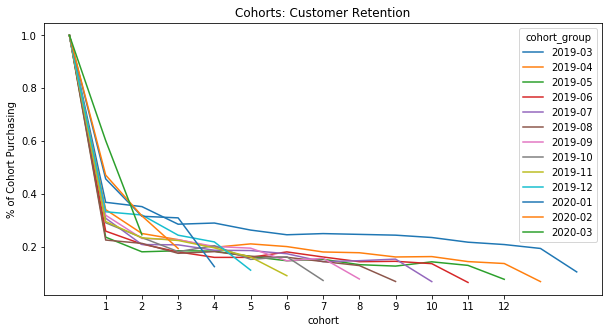

In [22]:
cohort_size = cohort_table.iloc[0, :]
cohort_table = cohort_table.divide(cohort_size, axis=1)
cohort_table.plot(figsize=(10,5))
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.ylabel('% of Cohort Purchasing');

We see all of these monthly cohorts seem to behave in a similar manner, we see fewer users purchasing as time passes with, on average, only 1/3 of customers repurchasing the following month with further drop offs as time goes on. March 2019 clearly has greater retention than the other months. We will use a heatmap to visualise the data another way:

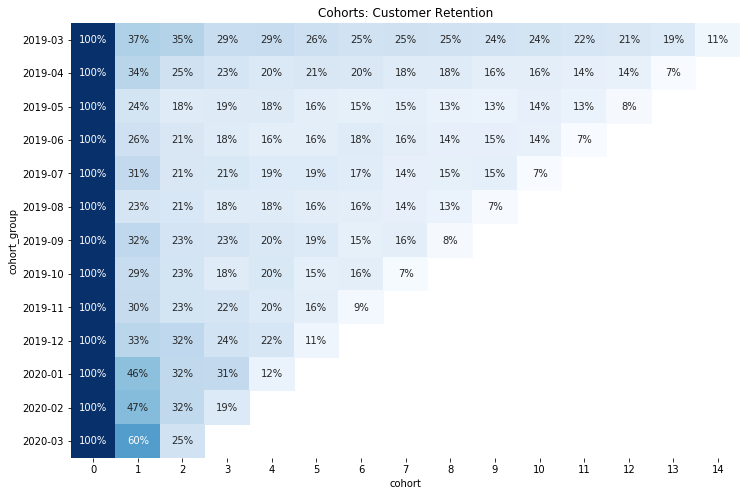

In [23]:
plt.figure(figsize=(12, 8))
plt.title('Cohorts: Customer Retention')
sns.heatmap(cohort_table.T, cmap= "Blues", annot=True, fmt='.0%', cbar = False);

What immediately jumps out is that we have 15 months of purchases, but only 13 cohort_groups. Every customer who ordered after March of 2020 had already previously purchased. Growth halted to a stop and all purchases were a result of customer retention. This seems odd, one major event during this time was the beginning of lockdowns around the world due to the Coronavirus. This, on it's own, does not explain why we saw no new customers for the remaining two months. Even if Slice totally halted all marketing during the liquidity crisis we would still expect word of mouth to drive new customers and it would also make sense that a lockdown lead to more takeaway purchases and thus more people looking for new avenues to purchase. 

Comparing the cohort_groups that we defined, we see that the March cohorts are the strongest, so we can ask questions about this month compared to others. We see customers who purchased in March of 2020 were roughly twice as likely to repurchase within a month than customers from other cohorts. This behaviour makes more sense in relation to the pandemic for the reasons above. Our acquisition cohorts are great for identifying churn trends, but it’s hard to make actionable insights on this data alone. There looks to be some seasonal pattern at a glance where first month retention falls in the summer and increases in the winter, but what other attributes besides the first purchase month do these users share?

We can look at behavioral cohorts where we filter our data by other features. In the dataset we have features that include the source of purchases, the shipping and payment types. Also, how do promos affect customer behaviour and does the state location show us anything interesting? Going further we could tap into other data sources, for example, were there any specific marketing campaigns, was the app redesigned or were features added/removed? Do we have data on abandoned baskets where users started to order and then gave up? Are there features within the app that some customers use that others do not?

To begin analysing our different features we will briefly stop grouping cohorts by customer first purchase and instead examine customers grouped by these features and the order period:

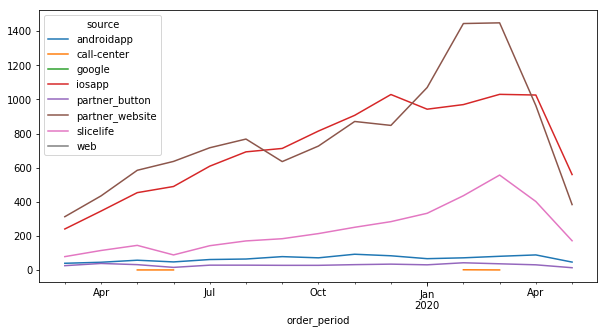

In [24]:
source_table = df.groupby(['source','order_period']).agg({
    'customer':pd.Series.nunique,}).reset_index(drop=False)
source_table.columns = ['source', 'order_period', 'Customers']

source_table = source_table.pivot_table(index='source', columns='order_period', values='Customers').T
source_table.plot(figsize = (10,5))

We see that the majority of unique users come via the partner_website, iosapp and slicelife. We also all the growth in unique customers from these sources, until around March 2020 where we see a steep decline. As we saw earlier we had no new customers after March 2020 but here whilst we see steep declines, they do no fall to zero. This simply means these users had previously purchased via another source.

We repeat this process for payment method, shipping type and state. For payment we see more people use credit than cash and that margin increasing over time. Shipping we see more people using delivery than pickup and similar rates of growth. For states we see the most customers and highest growth from NY, NJ and PA. These are all fairly predictable results. Promotional value shows some interesting results:

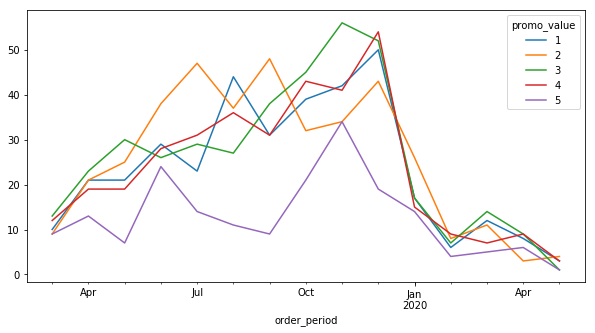

In [25]:
source_table = df.groupby(['promo_value','order_period']).agg({
    'customer':pd.Series.nunique,}).reset_index(drop=False)
source_table.columns = ['promo_value', 'order_period', 'Customers']

source_table = source_table.pivot_table(index='promo_value', columns='order_period', values='Customers').T
source_table.iloc[:,1:].plot(figsize=(10,5))

We see more and more new customers using promotions until 2020. This could reflect a change in the nature of the promotions or a change in the marketing of these promotions. This large fall in promotional could be linked to halting of growth.

Another way to look at these features is to filter our datasets by the features we are interested in and create customer retention heatmaps and compare the differences.

Rather than creating many different cohort tables for every different permutation of data subsets it is more robust to build a function that creates these visualisations and lets you input different parameters to reflect the different features.

In [26]:
def _gen_cohorts(dataset, metric, percentage):
    """
    This function creates cohorts of our data.
    Metrics defined are 'Customers', 'Number of Orders' or 'Order Value'.
    Use percentage = True to convert values into percentages.
        
    """
    
    cohorts = dataset.groupby(['cohort_group','order_period']).agg({
        'customer':pd.Series.nunique, 'order_id':pd.Series.nunique, 'restaurant_total':sum}).reset_index(drop=False)
    cohorts.columns = ['cohort_group', 'order_period', 'Customers', 'Number of Orders', 'Order Value']
    
    cohorts['cohort'] = (cohorts.order_period - cohorts.cohort_group)
    
    cohorts = cohorts.pivot_table(index='cohort_group', columns='cohort', values=metric)
    
    if percentage:
        cohort_size = cohorts.iloc[:, 0]
        cohorts = cohorts.divide(cohort_size, axis=0)
    
    return cohorts

def _gen_freq(dataset, metric):
    """
    This function creates our dataframe used to calculate repeat data.
    Metrics defined are 'Customers', 'Number of Orders' or 'Order Value'.
    """
    
    freq = dataset.groupby(['cohort_group', 'type_of_order']).agg({
        'customer':pd.Series.nunique, 'order_id':pd.Series.nunique,'restaurant_total':sum}).unstack()

    freq = freq.stack().T.stack(level=0).fillna(0)
    freq['percentage repeat'] = freq['repeat']/freq.sum(axis=1)
    freq = freq.unstack(level=0).iloc[:,-3:]
    
    freq.columns = ['Customer Returns', 'Return Orders', 'Return Value']

    if metric == 'Customers':
        select = 'Customer Returns'
    if metric == 'Number of Orders':
        select = 'Return Orders'
    if metric == 'Order Value':
        select = 'Return Value'
    if not select:
        raise NotImplementedError('Incorrect metric')

    freq = freq[select].reset_index()
    
    return freq, select

def cohort_analysis(df, metric, source='all', shipping='all', payment='all', state='all', period_agg='monthly',
                    size=10, save_fig=True, promo = 'all', percentage=False):
    """
    This function is used for the visuliasation of our cohert data.
    Metrics defined are 'Customers', 'Number of Orders' or 'Order Value'.
    Use source to filter by specific purchase method e.g. 'iosapp'.
    Use shipping to filter by specific shipping method e.g. 'Delivery'.
    Use payment to filter by specific payment method e.g. 'cash'.
    Use state to filter by specific state abreviation e.g. 'NY'.
    Use promo to filter whether any promotion was used, use 'yes' for any promo or 0-5 for specfic promo values.
    Use percentage = True to convert values into percentages.
    """

    dataset = df.copy()
    
    # Data subset defined by features choosen 
    if source != 'all':
        dataset = dataset[dataset.source == source]
        
    if shipping != 'all':
        dataset = dataset[dataset.shipping_type == shipping]
        
    if payment != 'all':
        dataset = dataset[dataset.payment_method == payment]

    if state != 'all':
        dataset = dataset[dataset.state == state]
        
    if promo != 'all':
        if promo == 'yes':
            dataset = dataset[dataset.promo_value > 0]
        elif promo == 1:
            dataset = dataset[dataset.promo_value == 1]
        elif promo == 2:
            dataset = dataset[dataset.promo_value == 2]
        elif promo == 3:
            dataset = dataset[dataset.promo_value == 3]
        elif promo == 4:
            dataset = dataset[dataset.promo_value == 4]
        elif promo == 5:
            dataset = dataset[dataset.promo_value == 5]

        
    # Choose cohort period length   
    if period_agg=='monthly':        
        dataset['cohort_group'] = dataset.groupby('customer')['date_purchased'].transform('min').dt.to_period('M')
        dataset['order_period'] = dataset['date_purchased'].dt.to_period('M')
        
    elif period_agg=='quarterly':    
        dataset['cohort_group'] = dataset.groupby('customer')['date_purchased'].transform('min').dt.to_period('Q')
        dataset['order_period'] = dataset['date_purchased'].dt.to_period('Q')
        
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not recognised')
        
    # Create cohorts
    cohorts = _gen_cohorts(dataset, metric, percentage)

    # Create new accounts data
    cohort_group_size = dataset.groupby('cohort_group').agg({'customer': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort_group', 'New']
    new_accs['cohort_group'] = new_accs['cohort_group'].apply(lambda x: str(x))

    # Create repeat data
    freq, select = _gen_freq(dataset, metric)
    freq['cohort_group'] = freq['cohort_group'].apply(lambda x: str(x))

    
    #### Plot the Data ####
    # Create grid
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14, 1)})
    sns.despine(left=True, bottom=True, right=True)
    
    # plot new accounts
    Accounts = sns.barplot(x="New", y='cohort_group', data=new_accs, palette="Blues", ax=ax1)
    Accounts.set(xlabel='Cohort Size', ylabel='Cohort Group')

    # plot heatmaps
    if percentage:
        fmt =".0%"
    else:
        fmt = ".0f"
        
    Heatmap = sns.heatmap(cohorts, cmap="Blues", annot=True, fmt= fmt, annot_kws={"size": size}, cbar=False,
                          yticklabels=False, ax=ax2)
    
    # Title defined by features choosen
    title0 = 'Filters: '; title1 = 'Source = '; title2 ='Shipping = '; title3='Payment = '; title4 = 'State = '
    
    if source != 'all':
        t1 = source
    else:
        t1 = 'all'
    if shipping != 'all':
        t2 = shipping
    else:
        t2 = 'all'
    if payment != 'all': 
        t3 = payment
    else:
        t3 = 'all'
    if state != 'all':
        t4 = state
    else:
        t4 = 'all'
    
    if source == 'all' and shipping == 'all' and payment == 'all' and state == 'all':
        titles = 'None'
    else:
        titles = title1 + t1 + ', '+ title2 + t2 + ', ' + title3 + t3 + ', ' + title4 + t4 

    title = title0 + titles    
    Heatmap.set_title(title)
    
    ax2.text(x=0.5, y=1.05, s='Retention Matrix for "{}"'.format(metric), fontsize=16, ha='center',
    va='bottom', transform=ax2.transAxes)
    
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('Cohort')

    # plot repeat table
    Repeats = sns.barplot(x=select, y='cohort_group', data=freq, palette="Blues", ax=ax3)
    Repeats.set_xlim(0,1)
    Repeats.set_xlabel("Repeat %")
    Repeats.yaxis.get_label().set_visible(False)
    Repeats.set(yticklabels=[])
    Repeats.set(yticks=[])
    vals = Repeats.get_xticks()
    #Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])
    plt.tight_layout()

We can now simply call our cohort_analysis function with our chosen parameters to create new heatmaps. To begin let's choose our basic customer retention map:

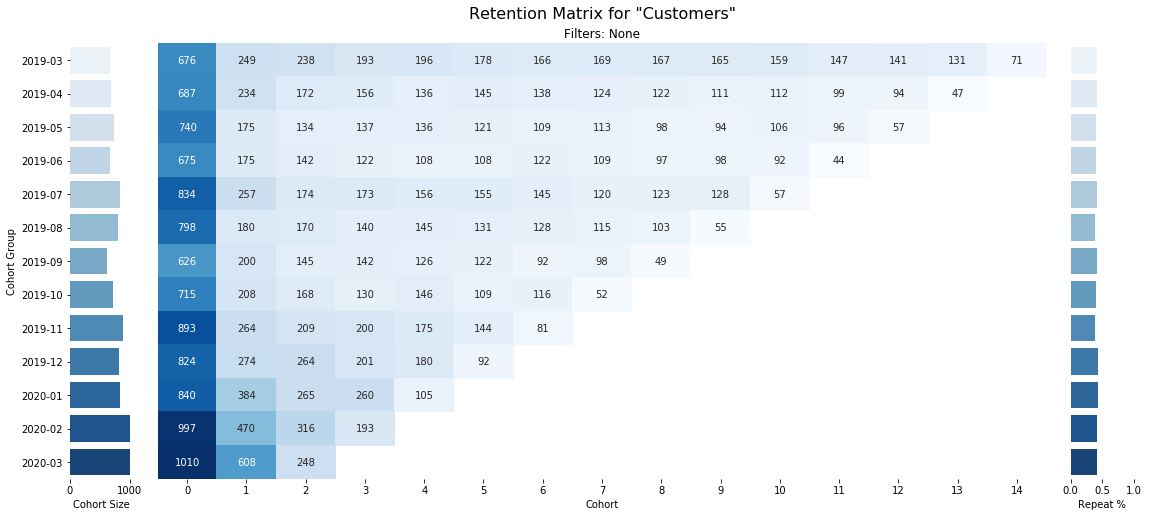

In [27]:
cohort_analysis(df, 'Customers')

We see the same heatmap as before but with two additional graphs. The left hand graph is a bar chart representation of the size of each cohort. The right side bar chart shows the proportion of repeat orders in this cohort. As well as customer retention, we can look at order retention or value retention, so we can see how total orders and value of purchases churn over time:

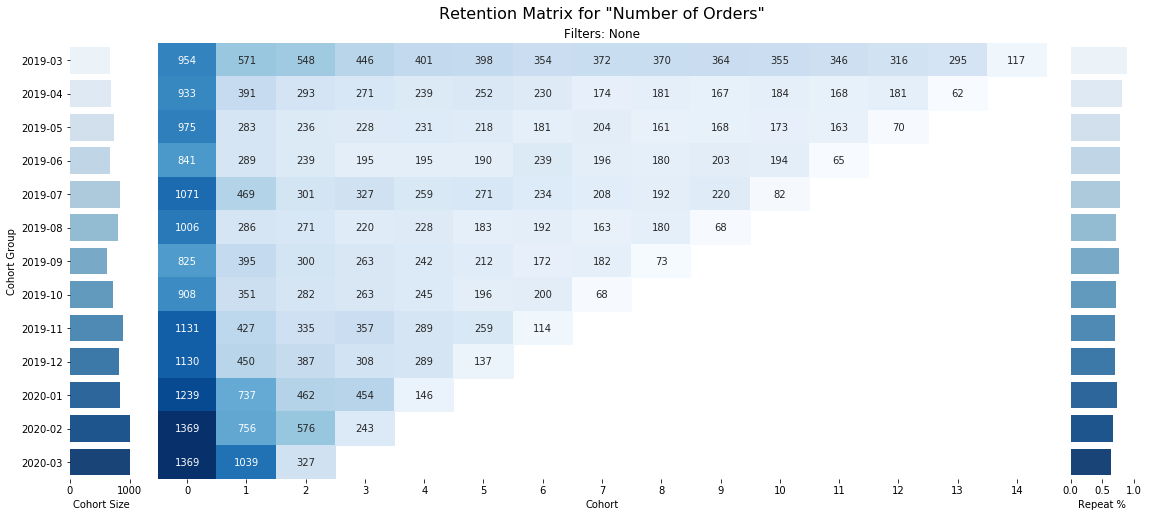

In [28]:
cohort_analysis(df, 'Number of Orders')

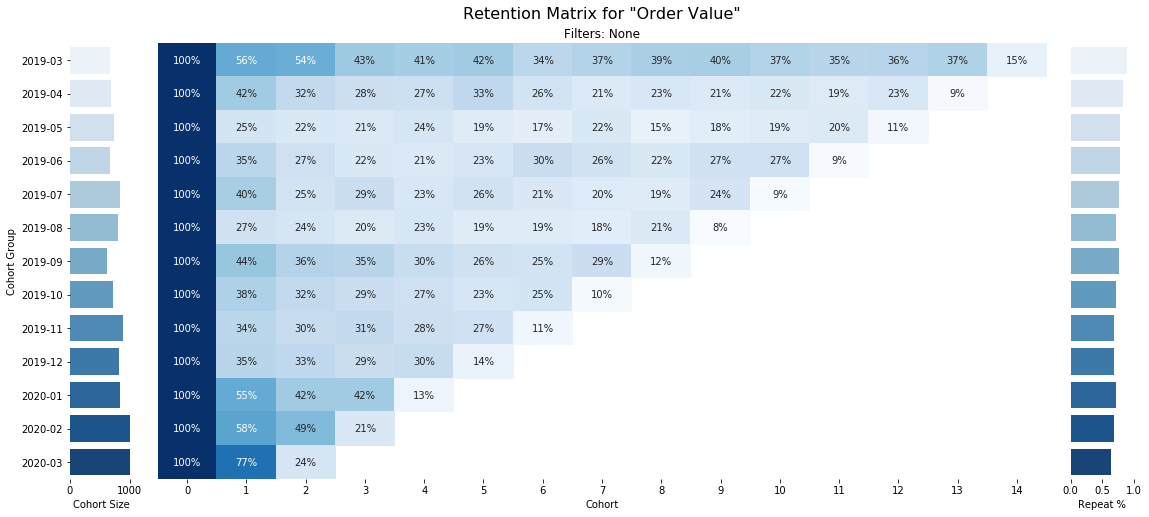

In [29]:
cohort_analysis(df, 'Order Value', percentage=True)

We can also change our raw values to percentages as seen above. Value retention after the first month in 2020 is much higher, this may reflect new strategy in 2020.

We can also use our features, let's compare customer retention of the iosapp vs the androidapp as percentages:

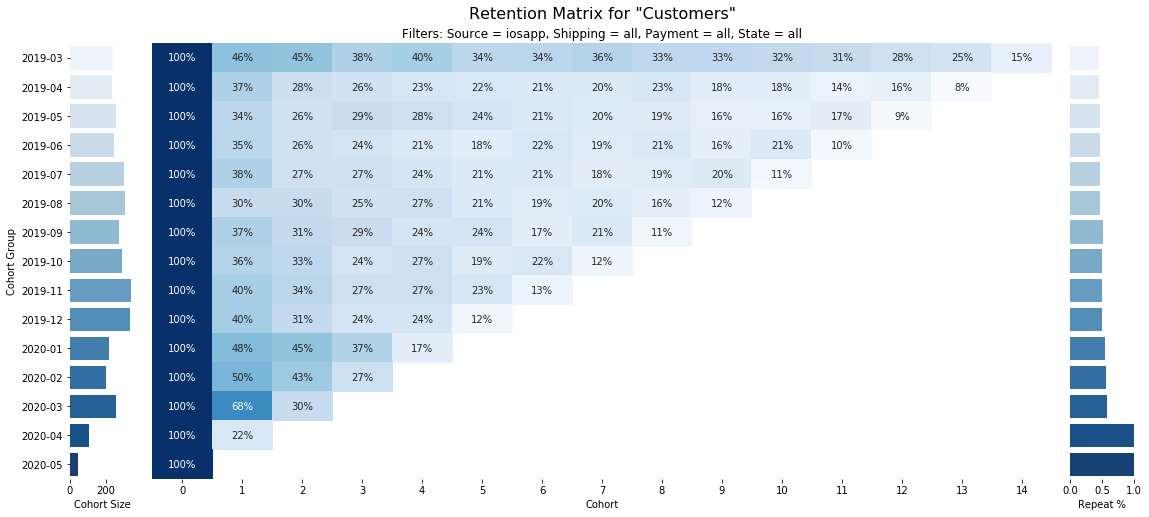

In [30]:
cohort_analysis(df, 'Customers', source = 'iosapp', percentage = True)

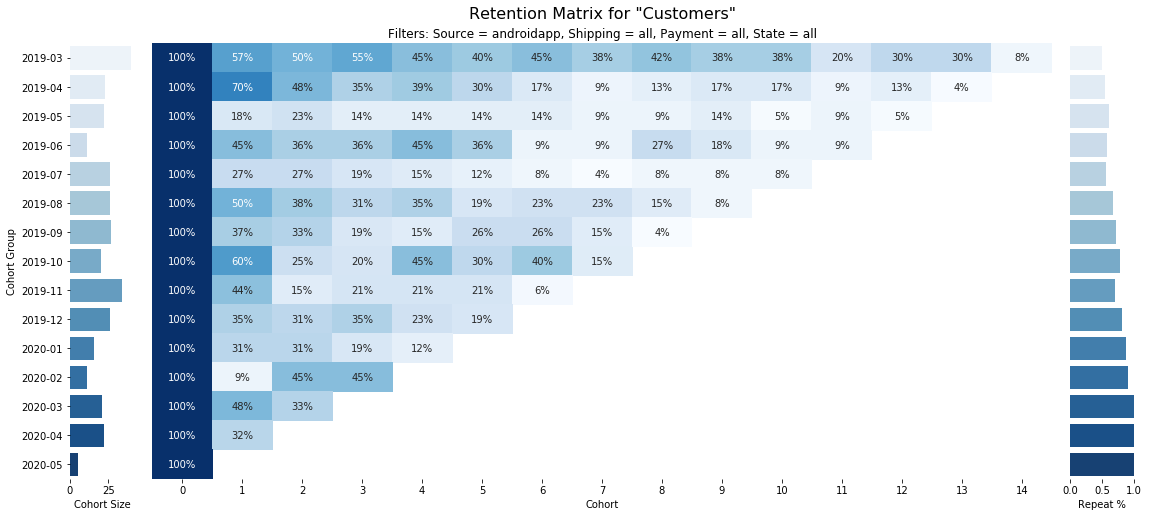

In [31]:
cohort_analysis(df, 'Customers', source = 'androidapp', percentage = True)

There are several insights we can gain from this comparison. Starting with the left hand side we see by the Cohort Size scale that the iosapp cohort sizes are much larger than for the androidapp. For both we see similar pattern in growth between cohort groups with both showing growth dips as we enter 2020, however we see more steady growth of iosapp users. <br>                   Whilst we see more new customers and more steady growth of customers with the iosapp, the right hand graph shows us that a larger proportion of customers are repeat customers for the androidapp. Does this reflect that iosapp customers make their first purchase from the app whereas more andoidapp customers first come from another source e.e. partner_website. Perhaps the marketing for each app platform differs.<br>
The heatmaps show us much more variance in the different cohort's customer retention for androidapp users, with both groups having good retention for the March 2019 and 2020 cohorts, which follows the pattern for the full set of data.

It looks like there is a more consistent behaviour with iosapp users, but we may be missing an opportunity as the androidapp users we do have show higher levels of repurchasing.

Lets look at the other sources with a significant number of customers (>1000):

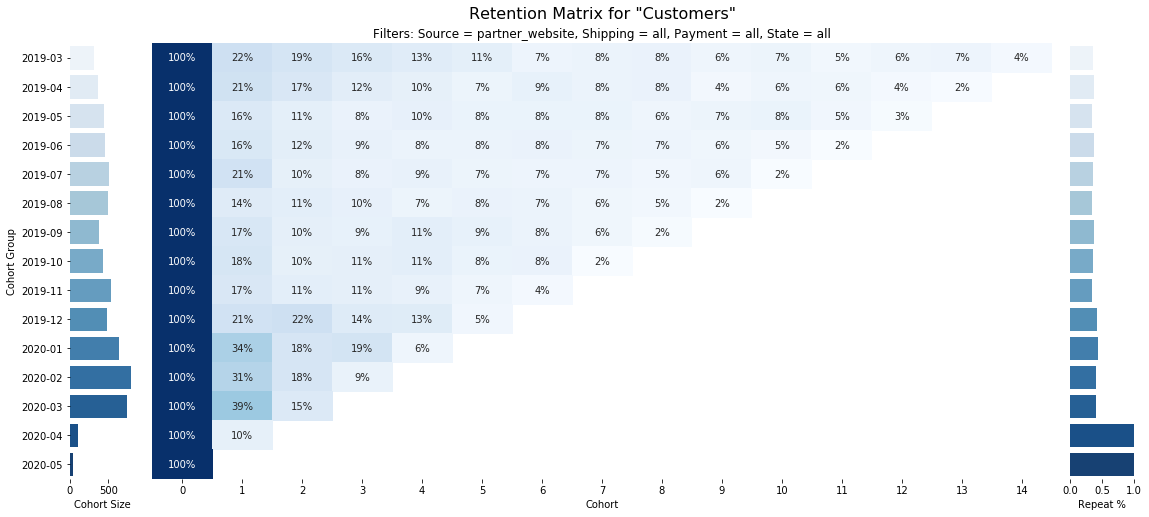

In [32]:
cohort_analysis(df, 'Customers', source = 'partner_website', percentage = True)

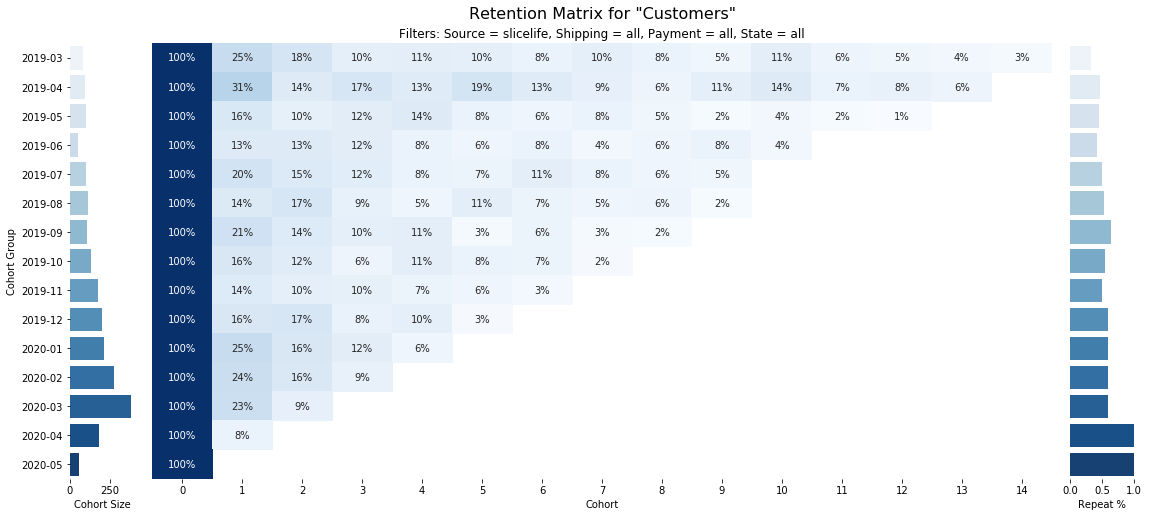

In [33]:
cohort_analysis(df, 'Customers', source = 'slicelife', percentage = True)

We observe a larger drop off of customer retention in the first month for slicelife and partner_website relative to the apps. We also see for the partner_website a much lower repeat levels than the other sources. <br>We see cohort groups for April and May 2020 when using a filter, but notice the repeat values are 100%, as these customers are only new to these filtered groups. The low partner_website repeats may explained by users moving to using one of the two app platforms or slicelife for their repeat orders.

Let us now look at the value retention of these sources, we will look at absolute value rather than percentage:

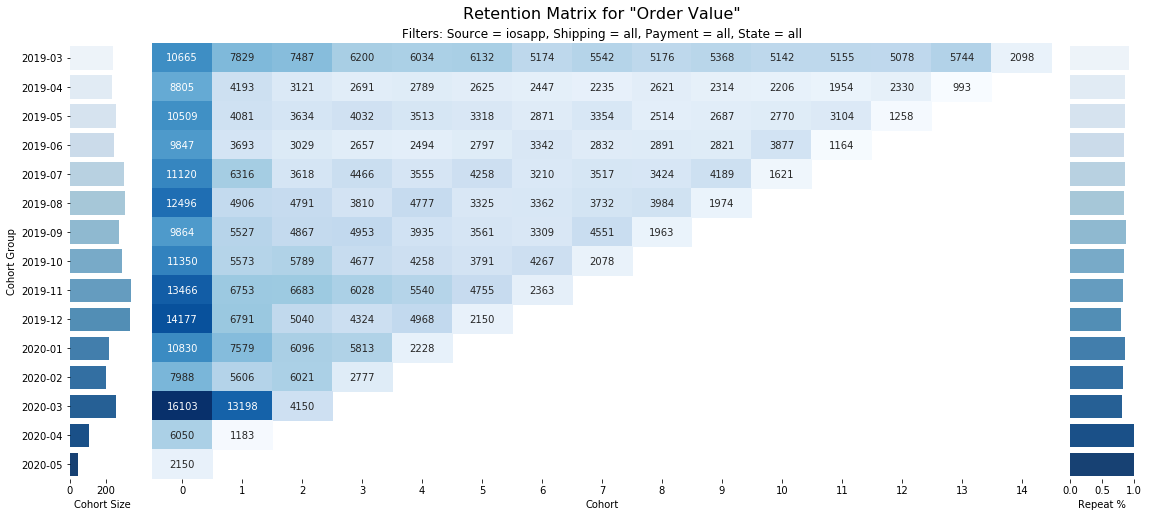

In [34]:
cohort_analysis(df, 'Order Value', source = 'iosapp')

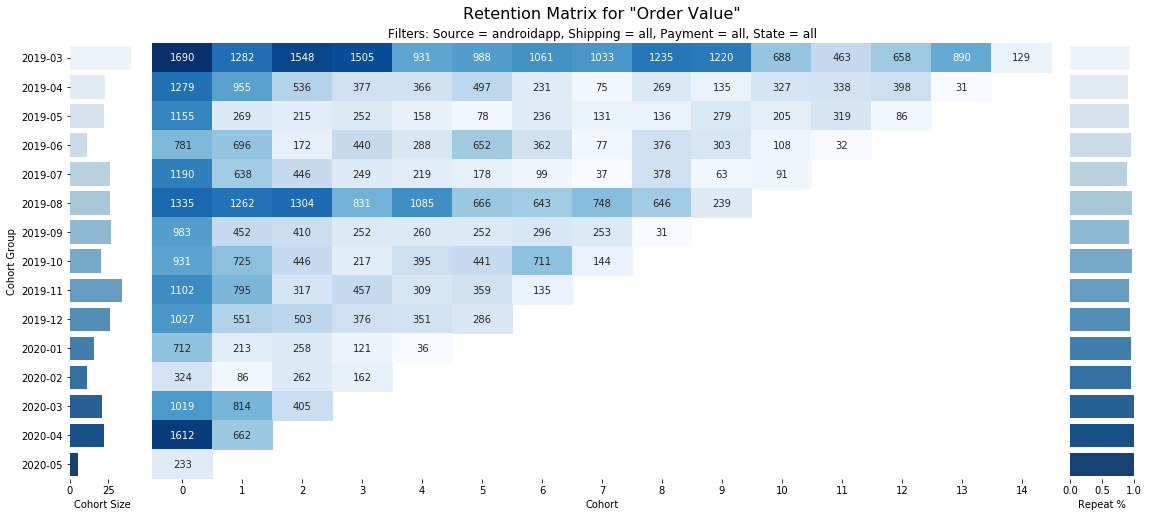

In [35]:
cohort_analysis(df, 'Order Value', source = 'androidapp')

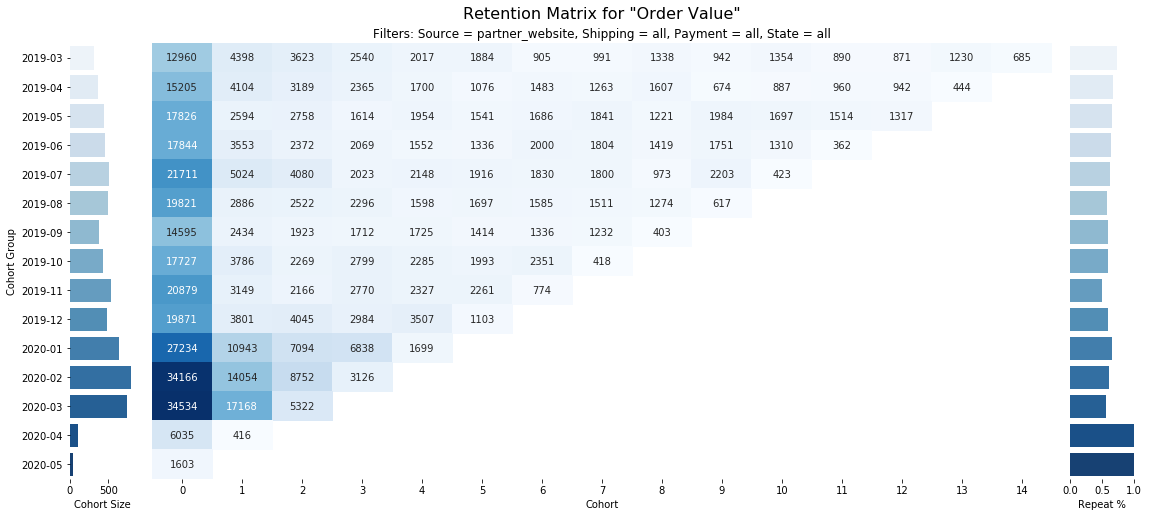

In [36]:
cohort_analysis(df, 'Order Value', source = 'partner_website')

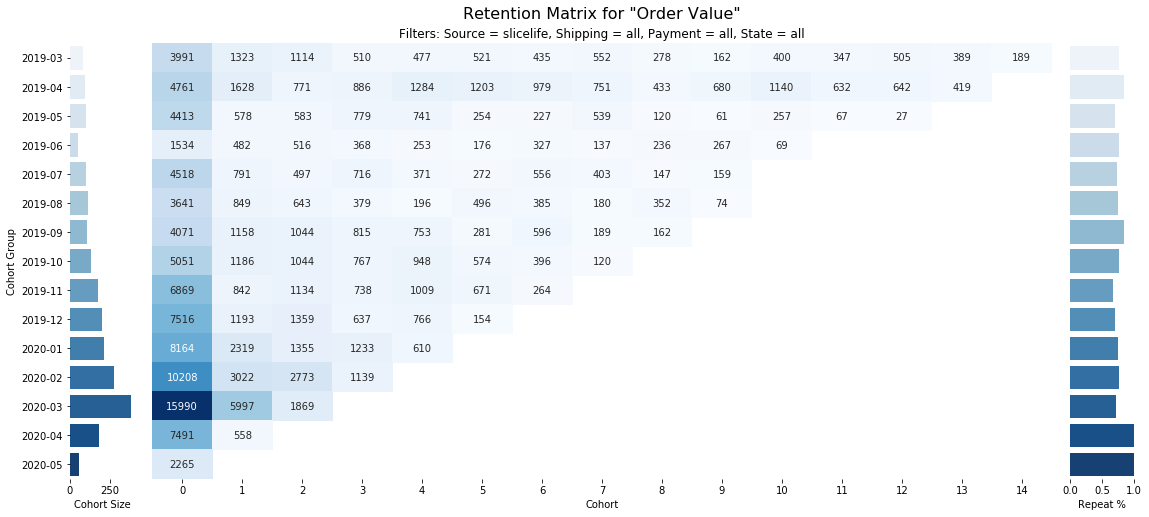

In [37]:
cohort_analysis(df, 'Order Value', source = 'slicelife')

For partner_website and slicelife we see lower value retention than androidapp and iosapp which follows the customer retention patterns. 
We see high value retention for the android app, with very high value retention for the 2019-08 cohort group. If we can isolate what differences there were between this cohort month and others and apply them we could increase profits dramatically. The repeat percentages are very high for androidapp customers also implying not only strong retention but also potentially a high proportion of these customers originally used another source like the partner_website before being grouped into this cohort.

There are only 605 orders using the partner_button and 110 using the web, but let's quickly see if anything sticks out:

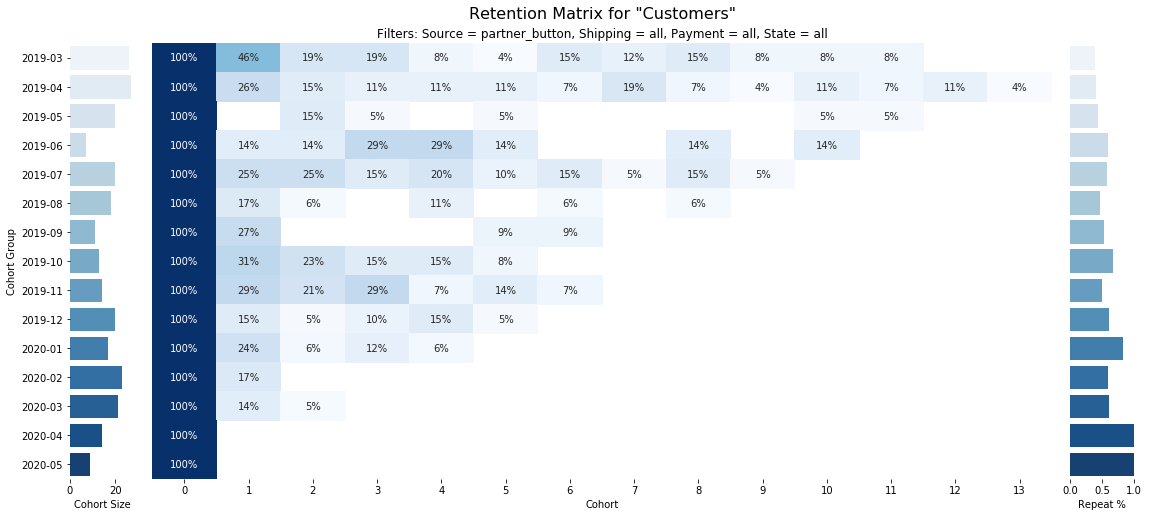

In [38]:
cohort_analysis(df, 'Customers', source = 'partner_button', percentage = True)

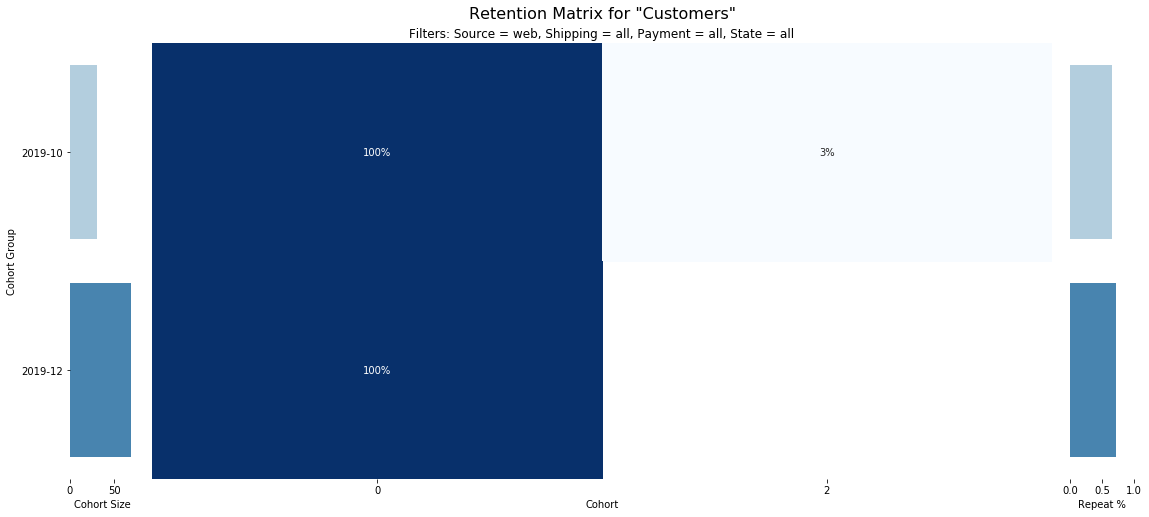

In [39]:
cohort_analysis(df, 'Customers', source = 'web', percentage = True)

The partner_button has similar distribution to the partner_website. Those who order from the web almost never come back using the web. The repeat percentage is very high as well, this helps us see that for most customers using the web, it is not their first order and if they do come back again they use a different source. 

I don't expect to gain much from filtering by shipping_type or payment_method but we will have a quick look. We expect delivery and credit to be common, especially given that most users use an app:

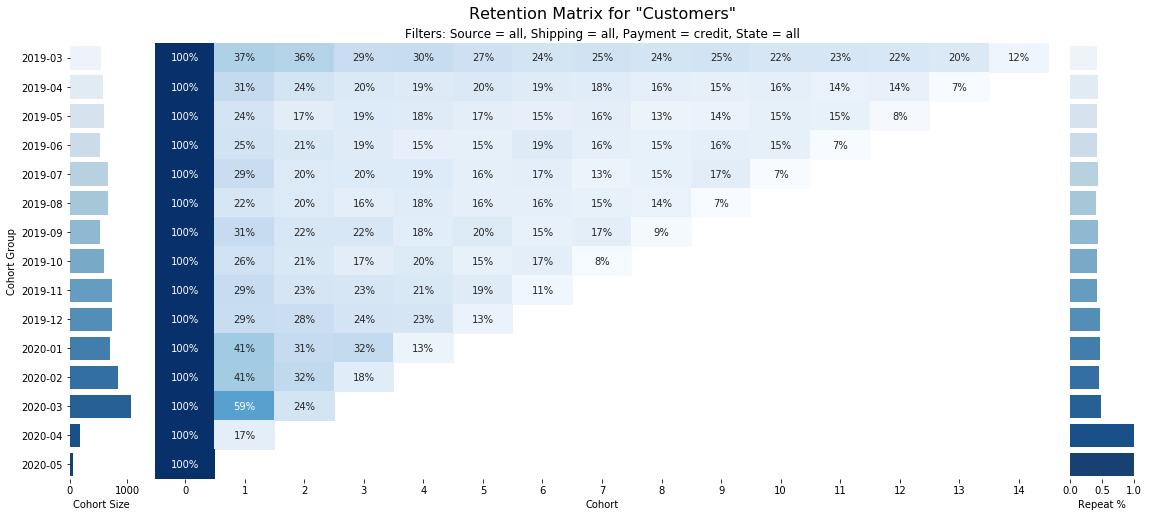

In [40]:
cohort_analysis(df, 'Customers', payment = 'credit', percentage = True)

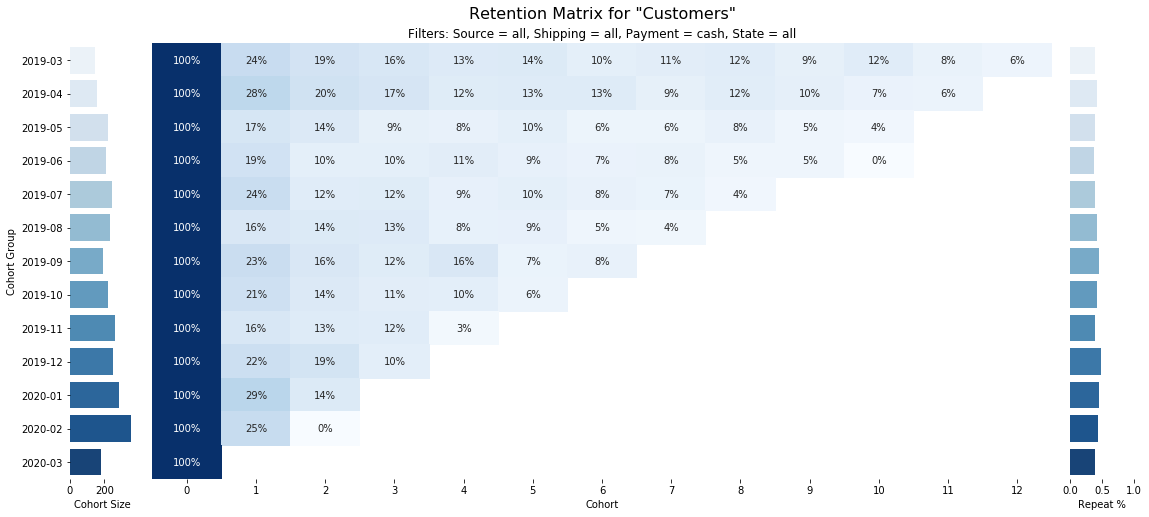

In [41]:
cohort_analysis(df, 'Customers', payment = 'cash', percentage = True)

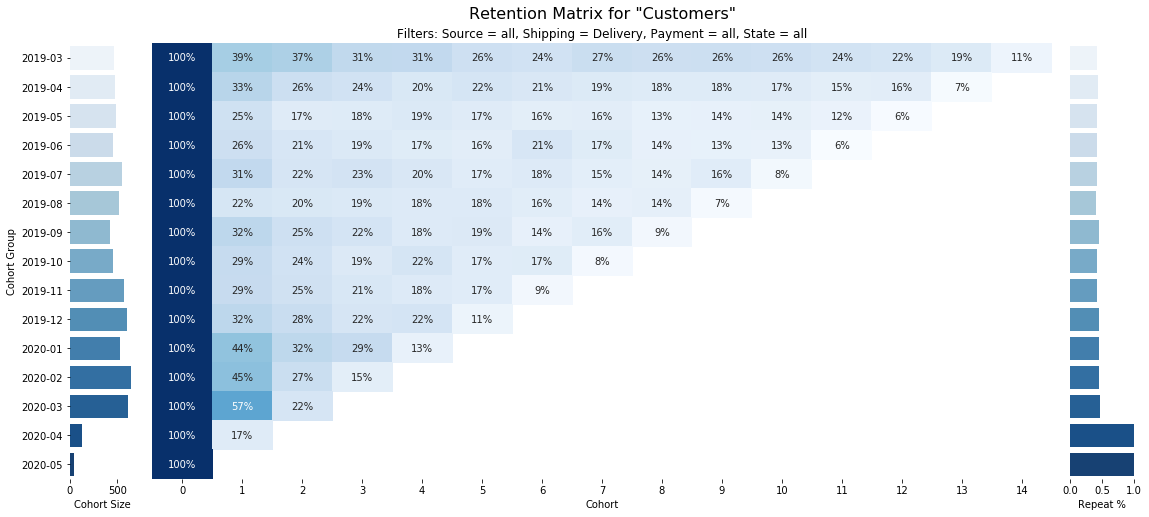

In [42]:
cohort_analysis(df, 'Customers', shipping='Delivery', percentage = True)

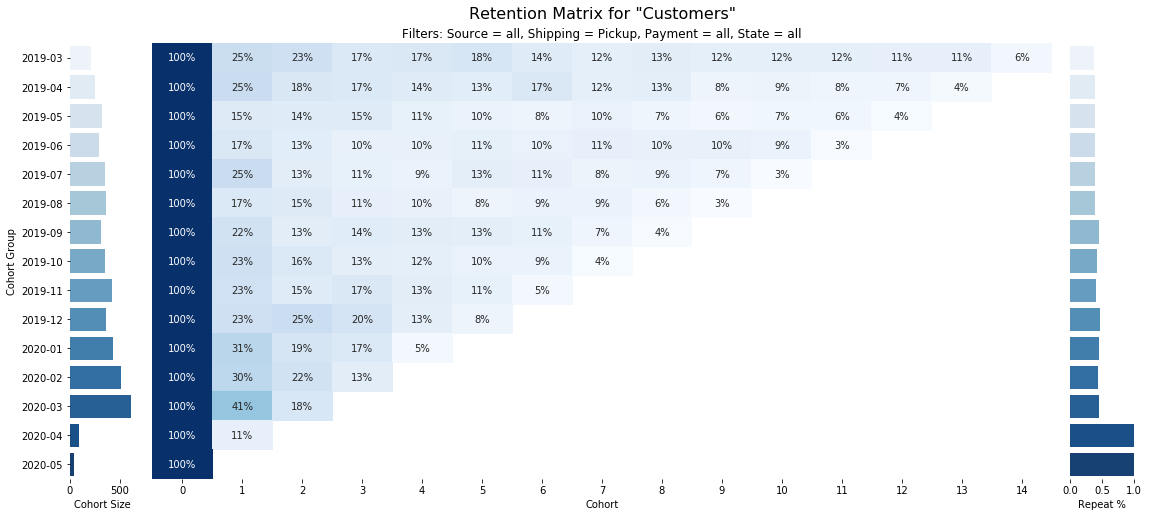

In [43]:
cohort_analysis(df, 'Customers', shipping='Pickup', percentage = True)

We see customers using credit are more likely to comeback as are customers using delivery, as expected.

Now we look at customers using promotions:

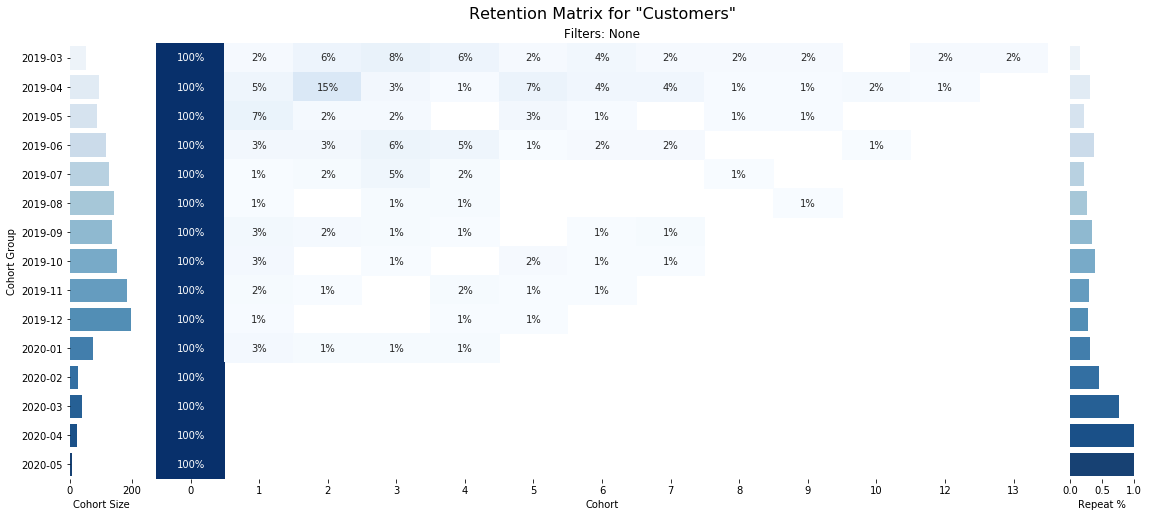

In [44]:
cohort_analysis(df, 'Customers', promo='yes', percentage = True)

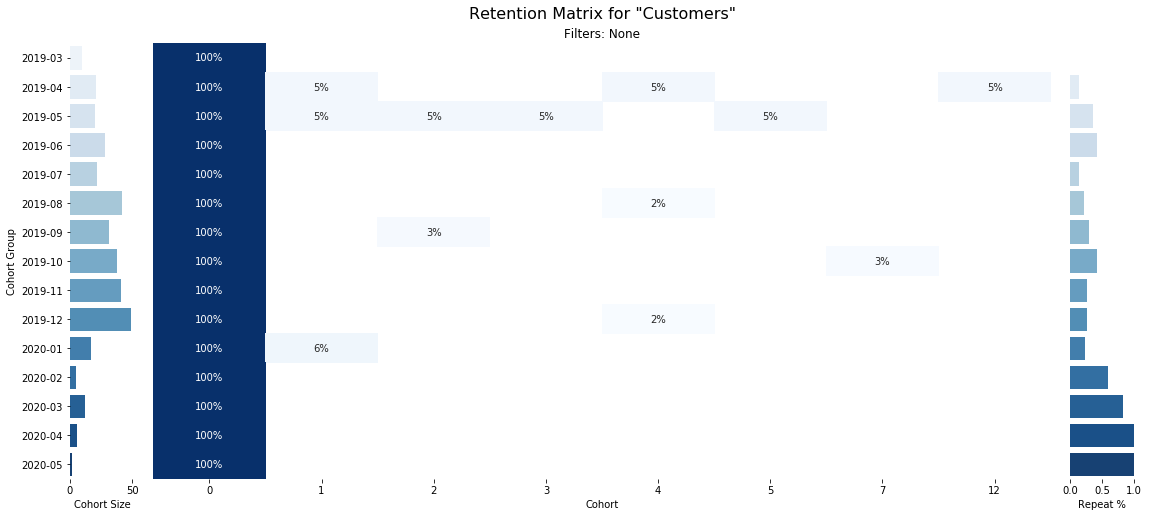

In [45]:
cohort_analysis(df, 'Customers', promo= 1, percentage = True)

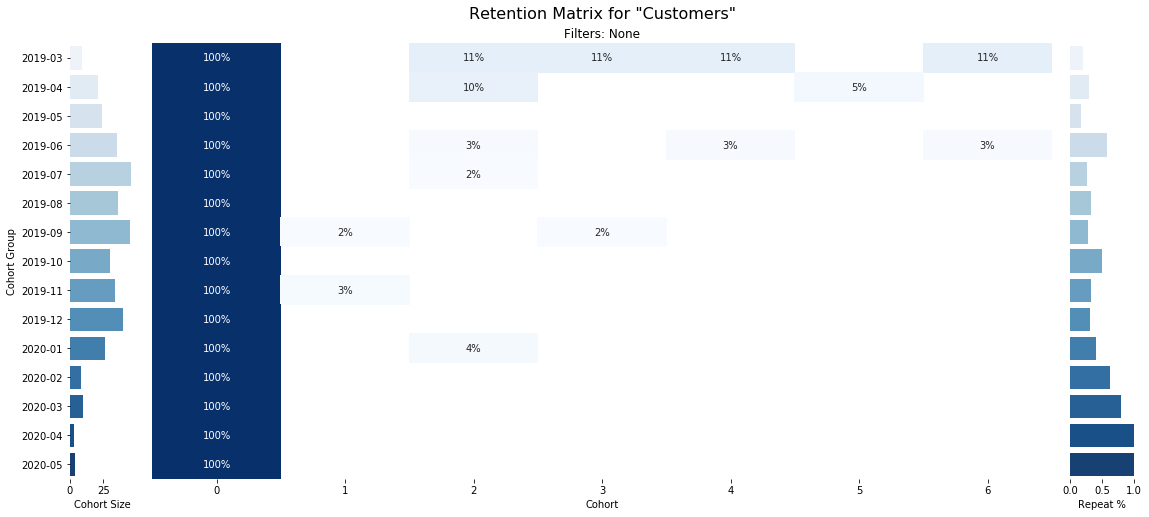

In [46]:
cohort_analysis(df, 'Customers', promo= 2, percentage = True)

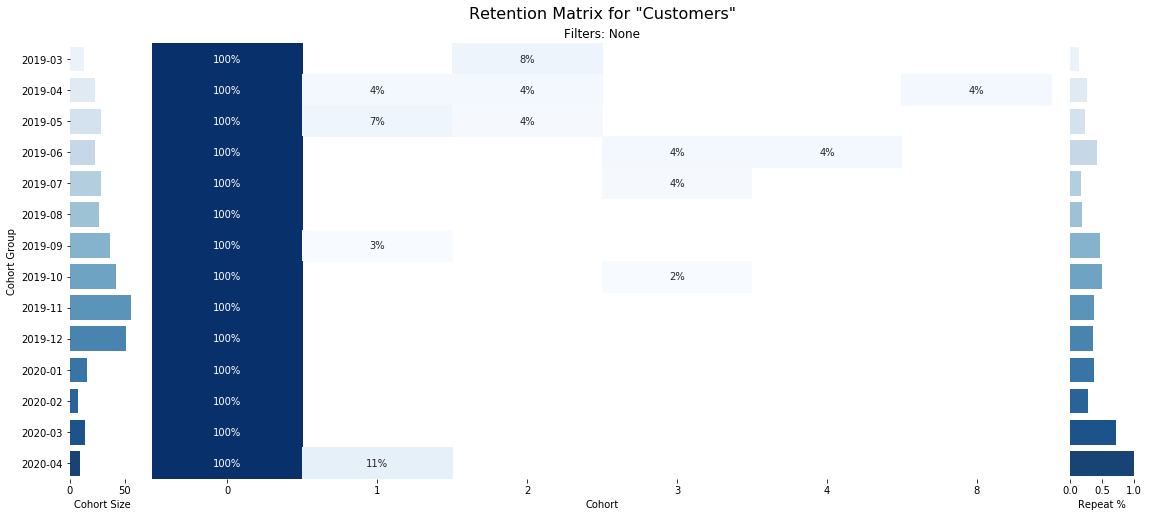

In [47]:
cohort_analysis(df, 'Customers', promo= 3, percentage = True)

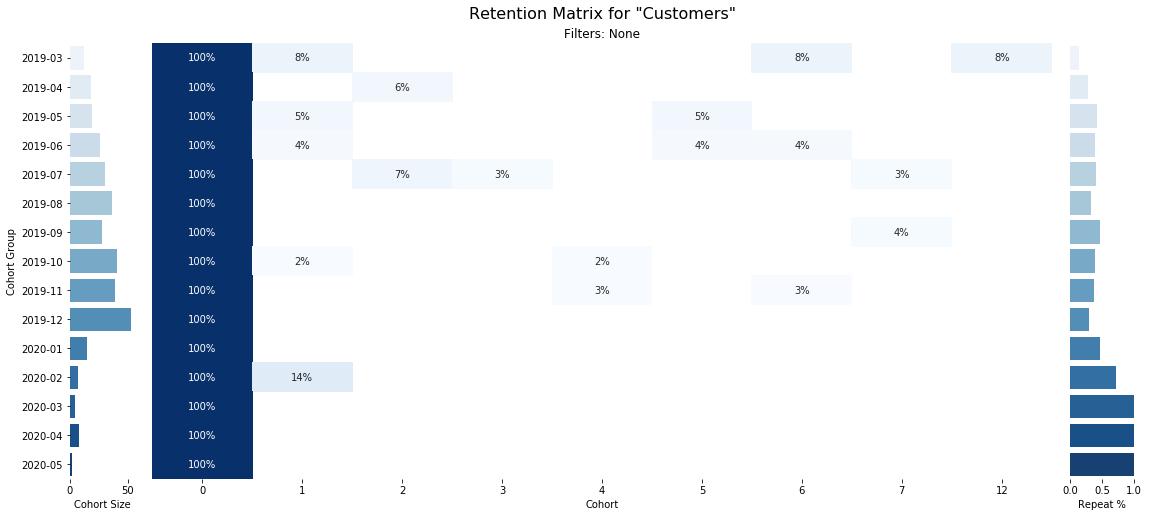

In [48]:
cohort_analysis(df, 'Customers', promo= 4, percentage = True)

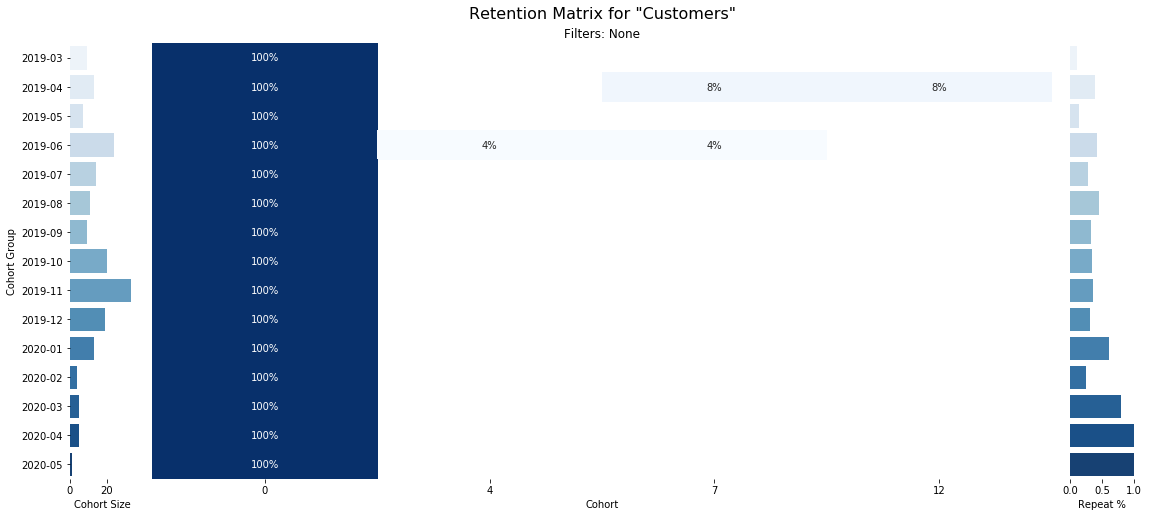

In [49]:
cohort_analysis(df, 'Customers', promo= 5, percentage = True)

As previously discussed, we see a large drop off in cohort size from promotional users after 2020. We also see a massive drop of in customer retention for promotional use at all values of promotion. This may be misleading however as it merely means customers who first used a promotion did not use any more promotions going forward, but they may have purchased without a promotion before or after being placed in these cohorts. As we see a very sharp drop off in retention, but the repeat percentages are often roughly 25%, this implies those percentages represent customers who first ordered without a promotion. 
We could dig deeper in the future by splitting customers into those who never used a promotion vs those who used a promotion at least once. Or we could look at customers who's first order used a promotion and analysed how they behave differently to users who didn't have any promotional incentive on their first order. 

One cohort grouping that may be more stable than the others previously explored is state. Location isn't a behavioural trait, but there may be differences in the way we interact with customers in different areas. We saw the majority of customers live in NY, NJ and PA so let us see how these three compare to each other:

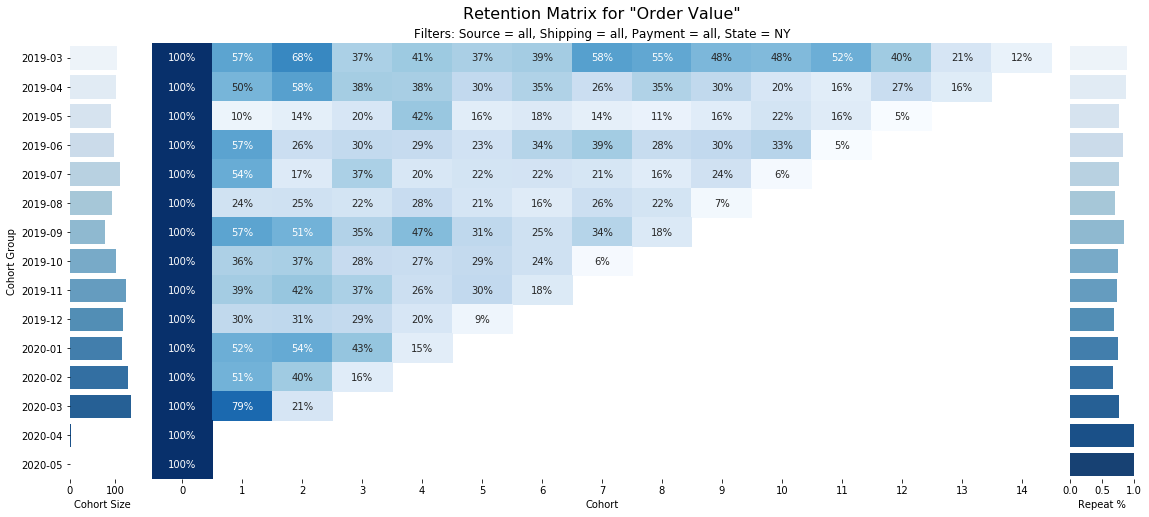

In [50]:
cohort_analysis(df, 'Order Value', state = 'NY', percentage = True)

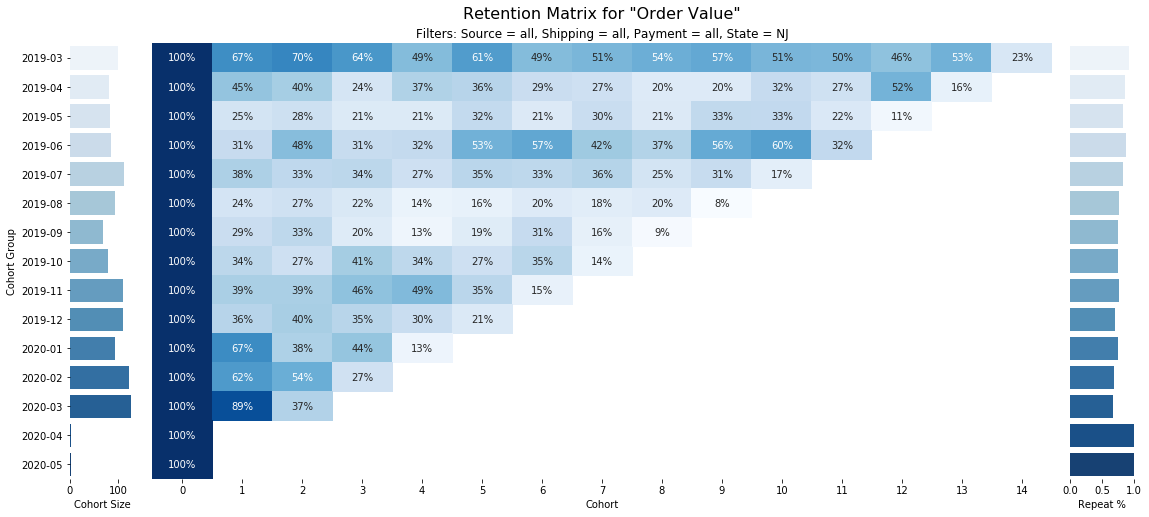

In [51]:
cohort_analysis(df, 'Order Value', state = 'NJ', percentage = True)

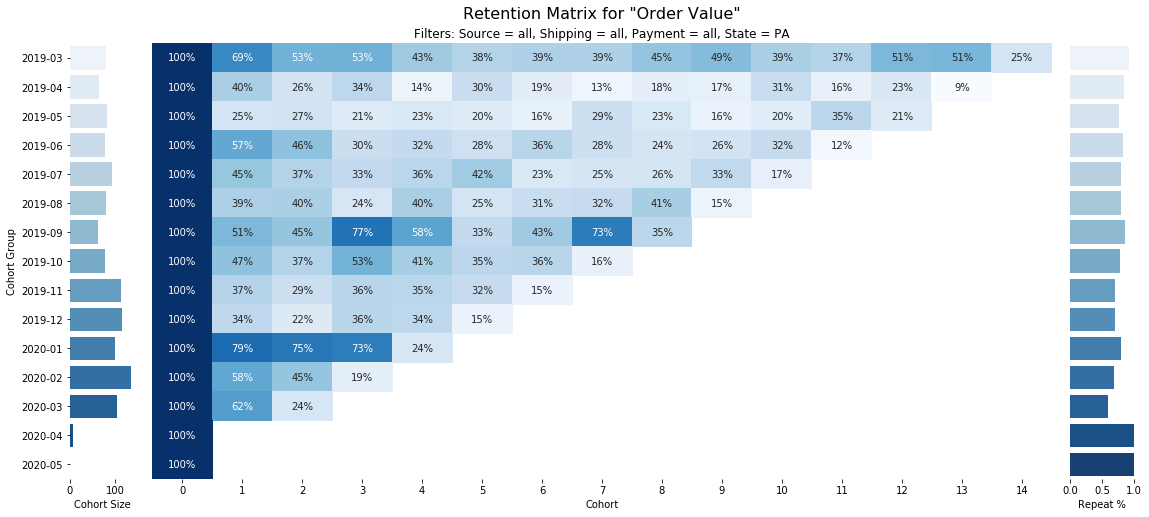

In [52]:
cohort_analysis(df, 'Order Value', state = 'PA', percentage = True)

These states show similar distributions to each other and to all the states combined. There are specific values that we can examine though, for example for all states we saw poor value retention for May 2019, and this is most seen in NY. So we can try and find out why this month was different and does it make sense that the reason we find was more significant in NY?

#### Conclusions

We see no new customers after March 2020, only repeat orders!

We see March cohorts are the strongest for retention of customers and value, and we also see increased retentions for 2020 relative to 2019. In particular August 2019 for androidapp customers has very strong value retention so if those customers were targeted in a specific way we would want to repeat that for other customers.

We split our data by months, but we could also compare different time periods. In addition, we could look at the relative time of orders, which would need to be adjusted using state timezone differences. You may find customers using different sources order at different times and then adjust the times in which each customer is targeted by marketing. 

Additional data that could be valuable is data on users who started ordering, but dropped their basket before purchasing. Or how if users opened an app to browse but never created a basket. Marketing data on who and how different groups of customers were targeted would be valuable and could potentially connect the dots between results seen here. We could see which individual stores have the best retention and see how they differ from other stores. The shops_id column has over 6000 unique values, but we could aggregate shops by factors such as the style of pizza they serve, the relative costs of the shop or how many competitors they have within a certain radius. These factors may affect churn.  

We could group orders by their order's value for example under \$10, \$10 - \$20 and more groups up to orders over \$100 and examine how retention of these groups differs. Other data that would be useful for insights could be total order time measuring the time between when the order is made and when the order is received. Shops with longer average order times may experience different churn rates or there may be differences in the way customers using different sources react to longer wait times. Metrics like order time that relate to customer experience can be used instead of time when comparing cohort groups and we can see how sensitive different subsets of customers are to these metrics and we could use this data to change the recommendations we make to different groups. For example, a long wait time may lead high churn for a customer using the partner_website whereas it may not make any difference to a customer using slicelife. We could use this knowledge to target partner_website customers with restaurants with fast order times and increase the chances of repeat business.

The limitations of this analysis is that customer behaviour often changes. A new customer may use the iosapp for their first order and then slicelife for the remainder of purchases. When we compare the two datasets, one customer would be seen as two unique customers. One of which uses the iosapp and never returns and another who we think becomes a customer at a later date and returns multiple times. The repeat graphs on the right are helpful in showing you what proportion of orders are reorders, but we don't know if those customers go on to join other cohorts due to changes in behaviour. When we compared the retention for payment methods we saw customers using cash were less likely to come back and use cash again, but they may have simply changed to credit for future orders. The same applies for differences in shipping type. This problem is even more prevalent when aggregating by promotion as a customer who uses a promotion may love the service and come back and pay full price for the rest of their customer life cycle. To overcome this, another way to look at the data could be defining cohort groups by first purchase as well as other filters like promotion or source. By labeling all their orders with their first purchase source, we could compare the retention of those who first ordered via the iosapp with those who first ordered via a partner_website and we wouldn't lose any data points if the customer then changed their source in future orders. This way we could compare the total life cycle of customers whose initial cohorts are defined by their first interaction with Slice. 